# Python Cribbage 
### by Tom Earnest
#### Python for Data Science, Fall 2017

# Introduction

![120-hole_cribbage_board.jpg](img/120-hole_cribbage_board.jpg)

<h1><center><font size="2">Cribbage board (https://en.wikipedia.org/wiki/Cribbage)</center></h1>

#### Background
<font size="3">[Cribbage](https://en.wikipedia.org/wiki/Cribbage) is one of the most rewarding and intricate card games for two persons (though some versions can be played by 3 or more people).  Cribbage is played with a standard 52-card playing deck, but it is often scored by pegs on a small wooden board (pictured above).  While I won't detail the rules of the game here (__I will actually withhold some key information!__ See the conclusion section below), I will present some aspects of the game which contain problems solvable with Python.

In each round, players are dealt 6 cards and have to decide on 4 cards to keep and 2 to discard, with the goal of keeping the cards which will maximize their score in a later phase of play (_the show_).  While this decision is sometimes obvious, it can be difficult due to the fact that the score of each player's hand depends on a randomly selected _starter_ card.  Each player treats the starter as if it is part of the hand.  So, for each of the 15 (${{6}\choose{4}}$) possible 4 card hands player can keep, there are 46 possible starter cards, giving 690 outcomes.  

<br>My main goal for this project was to write a code to determine which cards are the best to discard; i.e. _what discard leaves the player with the hand that has the highest score on average?_  To do this, I first needed to write a script which scores a given final cribbage hand of 5 cards (player's 4 cards + starter).

#### Objectives:
1.  Develop a Python function that scores a given cribbage hand.
2.  Develop a Python function that identifies the highest scoring discard for a cribbage hand.

#### Objective 1:  The Scoring Function

Imagine we know the starter and we know player's hand; how do we score it, and how can we code that?  Here's what gets you points in cribbage:
- _Pairs_:  Holding two cards of the same value gives you __2 points__.  Treat a three-of-a-kind as 3 unique pairs (__6 points__) and a four-of-a-kind as 6 unique pairs (__12 points__).


- _Runs_:  Any group of 3, 4, or 5 cards (regardless of suit) in sequential order gives you as many points as the length of the run, i.e. __3, 4, or 5 points__.  Aces are low and runs cannot "wrap around" (e.g. A-2-3 is a valid run, Q-K-A-2 is not). Count all unique runs (e.g. 3-4-5-5 is called a "double run of three" and is 8 points, but this is simply because it is two runs of three (3 points each) and a pair (2 points).  Note that 3-4-5-6 counts as a single run of 4, not two runs of three.


- _Fifteens_: Any group of cards that sums to 15 counts for __2 points__.  Face cards (jack, queen, king) have a value of ten, and aces have a value of 1; all other number cards count for their own value.


- _Flushes_:  You get __4 points__ if you kept 4 cards of the same suit, regardless of their value.  If the starter turns out to be the same suit as your flush, you score __5 points__.  However, a flush is only scored if the player holds 4 cards of the same suit


- _"His Nobs"_: A peculiar name for a peculiar rule: if you hold a Jack, and the starter turns out to be the same suit as your Jack, you get __1 point__.

![rsz_2img_20171210_194720.jpg](img/rsz_2img_20171210_194720.jpg)
<h1><center><font size="2">Test yourself on these tricky hands to score; taken from my own cribbage board's manual.</center></h1>

Here is the code for the function I defined, with some markdown to clarify what is going on.  By no means the quickest or cleanest way, but it works!



In [1]:
#OBJECTIVE 1: THE SCORING FUNCTION

#Defines a function "crib_score()" which takes 5 string arguments and returns their cribbage score (where the first four inputs
#are player's hand and the fifth input is the starter.  Has one optional readout arugment which defaults to "num".  
#If set to "num", the function only returns the score, if set to "nice", the function will return the cribbage score 
#as well as where the score comes from (i.e. pairs, 15s, etc.).  

def crib_score(card1, card2, card3, card4, starter, readout="num"):
       
    #creates some lists which will be useful for calculating the score
    
    deal_4 = [card1, card2, card3, card4] #raw list of player's original hand
    hand = []  
    suits_4=[]
    for i in range(len(deal_4)):
        suits_4.append(deal_4[i][-1]) #saves the suits of player's kept cards; needed for scoring a flush
        hand.append(deal_4[i]) #creates a duplicate of deal_4, but we append the starter card in the next step
   
    hand.append(starter)
    
    #here are some elif conditionals which determine whether the function runs; start by setting proceed as a gate
    #and deck as a list of the valid possible entries
    
    proceed = 1   
    deck = ["AD", "2D", "3D", "4D", "5D", "6D", "7D", "8D", "9D", "10D", "JD", "QD", "KD",
            "AC", "2C", "3C", "4C", "5C", "6C", "7C", "8C", "9C", "10C", "JC", "QC", "KC",
            "AS", "2S", "3S", "4S", "5S", "6S", "7S", "8S", "9S", "10S", "JS", "QS", "KS",
            "AH", "2H", "3H", "4H", "5H", "6H", "7H", "8H", "9H", "10H", "JH", "QH", "KH"]
    
    #iterates over player's hand, makes sure the entries are 1) valid cards and 2) non-duplicates.
    #proceed is reset to 0 if a problem is detected; an error message is printed
    
    for i in range(len(hand)):
        if hand[i] not in deck:
            print("Invalid hand!  " + str(hand[i]) + " is not a valid card.\n\nEnter cards as strings where the card value immediately precedes the suit.  E.g.\n\n2 of hearts = '2H'\nJack of spades = 'JS'\n\nThe fifth entry should be the starter.")
            proceed = 0
            break
        elif len(hand) != len(set(hand)):
            print("Invalid hand!  Your hand has duplicate cards.")
            proceed = 0
            break    
    
    if proceed == 1:
    
    #checkpoint passed; import itertools which is extremely useful for computing subsets.  Make more lists which will be used
    #for calculating specific parts of the score
    
        import itertools
        
        hand_raw = []
        hand_nums = []
        hand_runs = []
        
        #hand_raw is an intermediary list which contains the value (i.e. A,2-10,J,Q,K) of each card.

        for i in range(len(hand)):
            hand_raw.append((hand[i][:-1]))
            
        #we use hand_raw to make some other useful lists.  For computing the runs score, we need to have all cards values as 
        #sequential numbers (1-13), while for computing the 15s, we need to reassign any ace values to "1" and any jack, queen,
        #or king values to "10".  This code loops through hand_raw and creates new lists with reassigned card values for 
        #sequencing(in hand_runs) or for summation (in hand_nums).

        for i in range(len(hand_raw)):
            if hand_raw[i] == "A":
                hand_nums.append(1)
                hand_runs.append(1)
            elif hand_raw[i] == "J":
                hand_nums.append(10)
                hand_runs.append(11)
            elif hand_raw[i] == "Q":
                hand_nums.append(10)
                hand_runs.append(12)
            elif hand_raw[i] == "K":
                hand_nums.append(10)
                hand_runs.append(13)
            else:
                hand_nums.append(int(hand_raw[i]))
                hand_runs.append(int(hand_raw[i]))
                
        #Time to start scoring!

        #Pairs: use itertools to generate all unique subsets of 2 in the hand (note we use hand_runs not hand_nums, since we 
        #want face cards to be treated as having unique values from each other) and store in pairs; this is a list of
        #tuples.  We iterate over these and check if the first value equals the second - when this occurs, increase the pair
        #score by 2.
    
        score_pairs = 0

        pairs = list(itertools.combinations(hand_runs, 2))
        for i in range(len(pairs)):
            if pairs[i][0] == pairs[i][1]:
                score_pairs += 2

        ###Runs: use itertools to generate all unique subsets of 3, 4, and 5 in runs, store as list of tuples.  We
        #iterate over this list and check if it meets these conditions: a set of unique numbers for which the (max-min)
        #is equal to the length-1.  If this is true, we should have a run, i.e. a set of sequential integers.  We store the 
        #length of each run in a new list, homeruns (because there will be runs scored!).  We do this to avoid a problem:
        #we need to score double (or more0 runs (e.g. 5-5-6-7) as multiple unique runs, but we need it to not count 
        #higher-order runs as multiple lower-order runs (i.e. 4-5-6-7 is one run of 4, not two runs of 3).  So, for scoring,
        #we check if homeruns is empty; if it isn't, we identify the max of homeruns (the longest run in player's hand), 
        #and we score the length of all the runs that are equal to the longest run.

        score_runs = 0

        nums = [3,4,5]
        runs = []
        homeruns = []

        for i in range(len(nums)):
            runs.append(list(itertools.combinations(hand_runs, nums[i])))

        for i in range(len(runs)):
            for j in range(len(runs[i])):
                if len(runs[i][j]) == len(set(runs[i][j])) and max(runs[i][j])-min(runs[i][j]) == len(runs[i][j]) - 1:
                    homeruns.append(len(runs[i][j]))

        if len(homeruns) != 0:
            score_runs += max(homeruns)*homeruns.count(max(homeruns))

        #Fifteens:  We use itertools to store a list (fifs) of all subsets of the hand which could sum to fifteen.  Here, we
        #use the hand_nums list generated above, which has already converted the values of aces, jacks, queens, and kings.
        #For each subset, we simply use the sum function and add 2 points when the sum is 15.

        score_fifteens = 0

        nums2 = [2,3,4,5]
        fifs = []

        for i in range(len(nums2)):
            fifs.append(list(itertools.combinations(hand_nums, nums2[i])))

        for i in range(len(fifs)):
            for j in range(len(fifs[i])):
                if sum(fifs[i][j]) == 15:
                    score_fifteens += 2

        #Flushes:  We check for a 5 card flush first; see if the suits (already stored in suits_4) of all of player's
        #cards are equal strings, and if the starter card's suit (will be at the [-1] position) is also equal.  If this is the 
        #case, add 5 points.  If not, check for a flush in just the player's hand.  If not, there is no flush.

        score_flush = 0

        if suits_4[0] == suits_4[1] == suits_4[2] == suits_4[3] == starter[-1]:
            score_flush += 5
        elif suits_4[0] == suits_4[1] == suits_4[2] == suits_4[3]:
            score_flush += 4
        else:
            score_flush = 0


        #Nobs:  Finally, look for any jacks in the player's hand - two conditionals need to be met for player to recieve a Nobs
        #score: 1) player must have a jack (check for cards where character [0] is "J") and 2) that jack must be in the same suit
        #as the starter (check for cards where the suit, the character at [-1] in deal_4, is the same as the starter suit).

        score_nobs = 0

        for i in range(len(deal_4)):
            if deal_4[i][0] == 'J' and deal_4[i][-1] == starter[-1]:
                score_nobs += 1
                
        #Now we simply total player's score so far...
        
        total_score = score_fifteens + score_runs + score_pairs + score_flush + score_nobs
        
        #and report the result!  If readout was specified to being "nice" when calling the function, we give a more comprehensive
        #output.
        
        if readout == "num":
            return total_score
        elif readout == "nice":
            print("\nFifteens:", score_fifteens)
            print("Runs:",score_runs)
            print("Pairs:",score_pairs)
            print("Flush:",score_flush)
            print("His Nobs:",score_nobs)
        
            print("\nTotal: " + str(total_score))

Great!  crib_score() can score cribbage hands for us; try some hands out in the cell below and verify them against the sheet above or with [Jeff Boulter's cribbage scorer](http://boulter.com/cribbage/), which accomplishes the same task.  The default is the highest scoring cribbage hand.

In [2]:
crib_score("5S","5H","5C","JD","5D",readout="nice")


Fifteens: 16
Runs: 0
Pairs: 12
Flush: 0
His Nobs: 1

Total: 29


### Objective 2: The Discard Function
Now we can use crib_score() to develop a new Python function, crib_discard().  This function will work on a 6-card hand and output the discard option which produces the highest score on average (i.e. depending on the starter).

In [3]:
#OBJECTIVE 2: THE DISCARD FUNCTION

def crib_discard(card1,card2,card3,card4,card5,card6):
    
    import itertools
        
    #sets the list of playing cards
    
    deck = ["AD", "2D", "3D", "4D", "5D", "6D", "7D", "8D", "9D", "10D", "JD", "QD", "KD",
                "AC", "2C", "3C", "4C", "5C", "6C", "7C", "8C", "9C", "10C", "JC", "QC", "KC",
                "AS", "2S", "3S", "4S", "5S", "6S", "7S", "8S", "9S", "10S", "JS", "QS", "KS",
                "AH", "2H", "3H", "4H", "5H", "6H", "7H", "8H", "9H", "10H", "JH", "QH", "KH"]
    
    #incorporates the users input into a list
    
    deal_6 = [card1, card2, card3, card4, card5, card6]
    
    #proceed value for catching some errors
    
    proceed = 1
    
    #checks if all the cards are in the deck, then checks if all cards are unique
    
    for i in range(len(deal_6)):
        if deal_6[i] not in deck:
            print("Invalid hand!  " + str(deal_6[i]) + " is not a valid card.")
            proceed = 0
            break
        elif len(deal_6) != len(set(deal_6)):
            print("Invalid hand!  Your hand has duplicate cards.")
            proceed = 0
            break
    
    if proceed == 1:      
        
        #sets the list of remaining cards in the deck (not in the player's hand)
        
        deck_rem = []
        for i in range(len(deck)):
            if deck[i] not in deal_6:
                deck_rem.append(deck[i])
        
        #creates a list of all unique 4 card sets within the 6 card deal
        
        hand_possible_4 = list(itertools.combinations(deal_6, 4))

        #creates some empty lists to store results
        
        handavg = []
        hand_final = []
        discard_final = []
        
        #loops over all the possible 4 card hands the player could get after discarding
        
        for i in range(len(hand_possible_4)):
            
            #handx stores the values of all possible scores for each discard (given by crib_score())
            handx = []
            
            #hand_final and discard_final store (in order) each possible 4 card hand and its respective 2 discards
            hand_final.append(list(hand_possible_4[i]))
            discard_final.append(list(set(deal_6)-set(list(hand_possible_4[i]))))
            
            #for each 4 card hand, computes crib_score() given any other card in the deck (i.e., for any starter computes the score)
            for j in range(len(deck_rem)):
                ls=[]
                ls = list(hand_possible_4[i])
                ls.append(deck_rem[j])
                handx.append((crib_score(ls[0],ls[1],ls[2],ls[3],ls[4])))
                
            #average score of the hand is computed, and appended into handavg
            handavg.append(sum(handx)/len(handx))
            
        #finds the best hand as the one with the highest score on average
        #also finds the corresponding discard
        best_hand =(hand_final[(handavg.index(max(handavg)))])
        best_discard = list(set(deal_6)-set(best_hand))
        
        #plots the results with matplotlib
        import matplotlib.pyplot as plt
        %matplotlib inline
        
        #replaces the letters with pips
        nice_labels = []
        for i in range(len(discard_final)):
            nice_labels.append(discard_final[i]) 
        for i in range(len(nice_labels)):
            nice_labels[i]=[w.replace("H","♡") for w in nice_labels[i]]
            nice_labels[i]=[w.replace("D","♢") for w in nice_labels[i]]
            nice_labels[i]=[w.replace("C","♣") for w in nice_labels[i]]
            nice_labels[i]=[w.replace("S","♠") for w in nice_labels[i]]
        
        #adds a space
        real_nice_labels = []
        for i in range(len(nice_labels)):
            real_nice_labels.append(nice_labels[i][0]+ " " + nice_labels[i][1])
        
        #plots the results as a bar plot; the average score for each discard is one bar
        fig, ax = plt.subplots(figsize = (10,10))
        barlist = plt.bar(range(len(handavg)), handavg, color="b")
        
        #sets the color of the highest scoring hand(s) to red
        max_inds = []
        for i in range(len(handavg)):
            if handavg[i] == max(handavg):
                max_inds.append(i)
                barlist[i].set_color('r')
                
        #sets some labels
        
        ax.set_xticks(range(len(handavg)))
        ax.set_xticklabels(real_nice_labels, rotation = 90)
        ax.set_ylabel("Average score")
        ax.set_xlabel("Discard")
        
        plt.show()

        #adds some additional information in the output, saying what the best discards are and their scores

        if len(max_inds) == 1:
            print("The best discard is " + str(real_nice_labels[handavg.index(max(handavg))]) + ".")
            print("\nAverage score with this discard: " + str(max(handavg)))
        elif len(max_inds) > 1:
            print('Any of these discards are best:\n')
            for i in range(len(real_nice_labels)):
                if i in max_inds:
                    print(real_nice_labels[i])
            print("\nAverage score with these discards: " + str(max(handavg)))

There we go!  crib_discard() will take a dealt cribbage hand and return the discard which will score highest on average.  It also makes a graph with matplotlib which highlights the best hands and how they compare to others.  Here are two examples of hands; one where there is a clear best discard, and another where there are multiple best options.

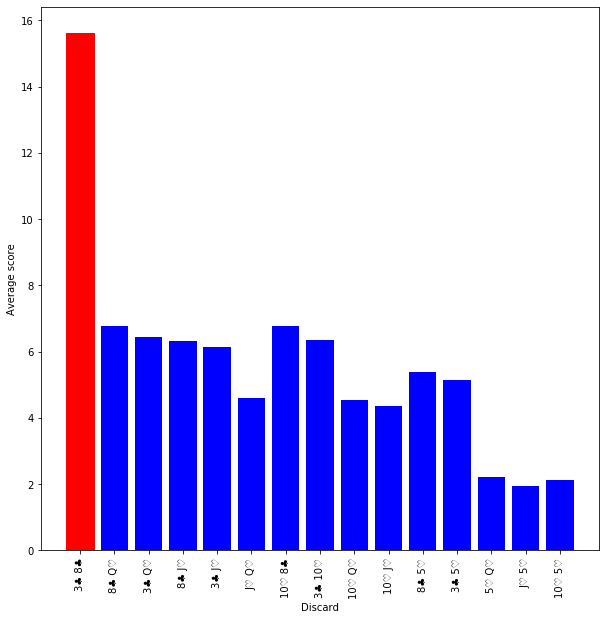

The best discard is 3♣ 8♣.

Average score with this discard: 15.630434782608695


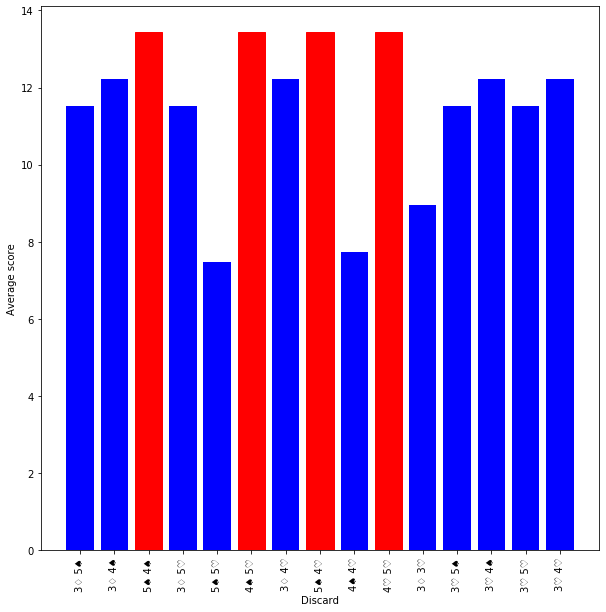

Any of these discards are best:

5♠ 4♠
4♠ 5♡
5♠ 4♡
4♡ 5♡

Average score with these discards: 13.434782608695652


In [4]:
crib_discard("5H","10H","JH","QH","3C","8C")
crib_discard("3H",'4H',"5H","4S","5S","3D")

## Limitations

Anyone who has played cribbage before will likely have recognized a major flaw with this program: it gives no consideration of the crib!  Indeed, this is an issue.  The discarded cards from each player's hand do not disappear into Purgatory; they instead go into the "crib", another set of 4 cards which is scored by the dealer as a second hand.  So, depending on who's dealt, the best choice of what cards to throw in the crib _might not be simply the ones which leave you with a high scoring hand_.  Rather, the best bet might be to discard the ones which maximize your crib + hand score when dealing, but minimize your opponent's crib when they have dealt.  This is especially crucial near the end of the game - cribbage is played to 121 points, and the dealer scores their hand last; if you and your oppponent are neck and neck, you want to minimize the points you allow your opponent.  E.g., you might opt to forego a discard that gives you a double run of three if it leaves a pair in opponent's crib.  Similarly, you may opt to take a chance on the discard which does not have the highest average score, but could have a _super_ score if the right starter is flipped.

[C. Liam Brown's Cribbage Discard Pro](https://cliambrown.com/cribbage/) is a wonderful web app which incorporates these considerations, providing you with different options for the best discard depending on the crib's owner and the player's desire (e.g. agressive, defensive, hail mary).  Brown also provides his general [methodology](https://cliambrown.com/cribbage/methodology.php); I would like to further develop my Python Cribbage towards the more comprehensive picture that Brown offers.  This would involve adding additional code to iterate through possible cribs and score these, and would need to report more results for the dealer and the non-dealer.  

Additionally, both my program and Brown's are entirely focused on the show (again, the final scoring phase of a cribbage round), and not _the play_ an intermediate phase which offers some points (although generally not as many as during the show).  I am currently unsure of how to incorporate this phase of play into a cribbage hand, but it might be something to look into.

<br><br>__Best of luck with your cribbage!__